In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime

In [2]:
# Define the stock symbol and date range
stock_symbol = 'GOOG'
start_date = '2012-01-01'
end_date = datetime.now()

In [3]:
# Get the stock quote
df = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


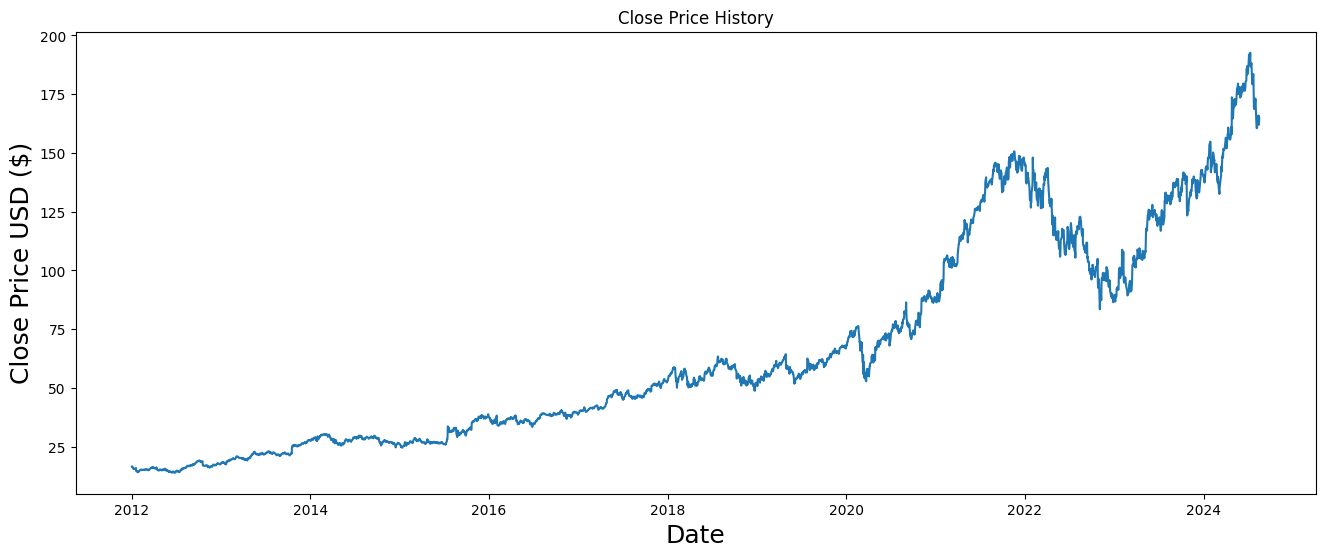

In [4]:
# Show the data
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
dataset = data.values

In [6]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * 0.95))
print(f"Training data length: {training_data_len}")

Training data length: 3018


In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [12]:
# Create the training data set
train_data = scaled_data[:training_data_len, :]
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)    

In [13]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

C:\Program Files\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)  # Increased epochs for better training

Epoch 1/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 1.4024e-04
Epoch 2/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - loss: 1.6934e-04
Epoch 3/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - loss: 1.3446e-04
Epoch 4/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 56s 19ms/step - loss: 1.5141e-04
Epoch 5/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - loss: 1.2475e-04
Epoch 6/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - loss: 1.3610e-04
Epoch 7/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 55s 19ms/step - loss: 1.2172e-04
Epoch 8/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - loss: 1.2278e-04
Epoch 9/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - loss: 1.1053e-04
Epoch 10/10
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - loss: 1.1386e-04


In [17]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [19]:
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"RMSE: {rmse}")

RMSE: 4.036384923791215


C:\Users\Manoj\AppData\Local\Temp\ipykernel_12968\2770638779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


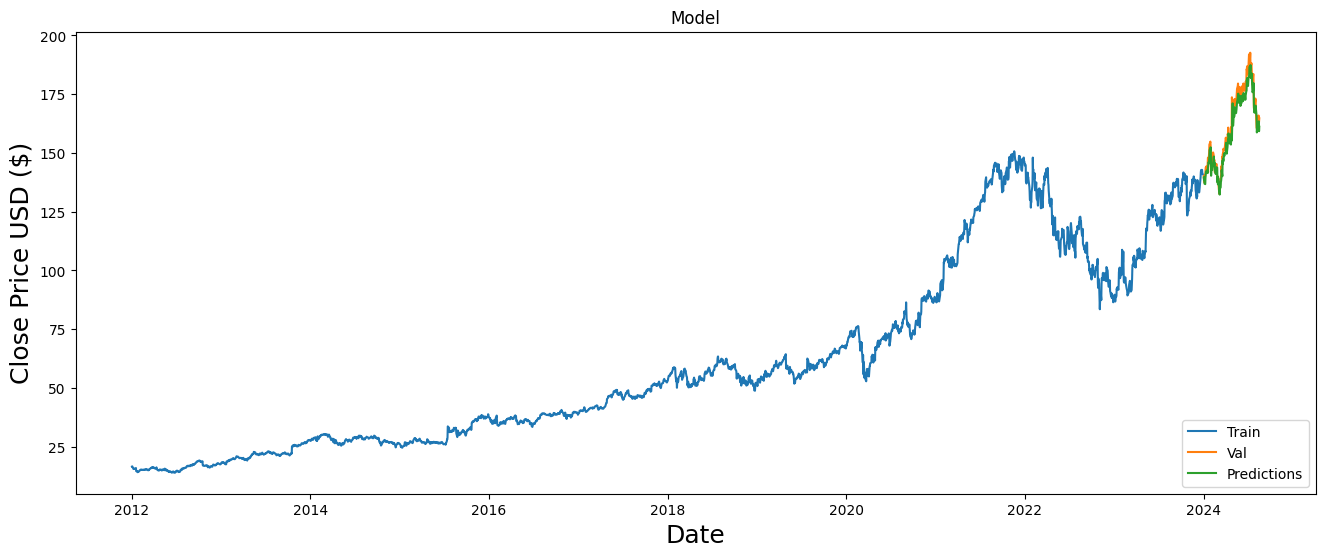

In [20]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
# Show the valid and predicted prices
print(valid)


                 Close  Predictions
Date                               
2024-01-02  139.559998   139.650284
2024-01-03  140.360001   138.411301
2024-01-04  138.039993   139.394226
2024-01-05  137.389999   136.935455
2024-01-08  140.529999   136.738388
...                ...          ...
2024-08-12  163.949997   162.765411
2024-08-13  165.929993   161.227341
2024-08-14  162.029999   163.464661
2024-08-15  163.169998   159.268143
2024-08-16  164.740005   161.176987

[158 rows x 2 columns]
